## Imports

In [12]:
from langchain.embeddings.ollama import OllamaEmbeddings
from langchain_community.vectorstores.faiss import FAISS, DistanceStrategy
from typing import List, Tuple
from langchain.docstore.document import Document
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

## General functions

### logic

In [2]:
def score_normalizer(val: float) -> float:
    return 1 - (1 / (1 + np.exp(val)))

# Define your custom similarity calculation function
def custom_relevance_score_fn(similarity_score: float) -> float:
    # Example calculation (customize as needed)
    relevance_score = np.exp(-similarity_score)
    return relevance_score

### display

In [3]:
def pretty_print_docs(docs):
    if isinstance(docs[0], tuple):
        print(
            f"\n{'-' * 100}\n".join(
                [
                    f"Document {i+1}: ({d[1]})\n\n{d[0].page_content}\nMetadata: {d[0].metadata}"
                    for i, d in enumerate(docs)
                ]
            )
        )
    else:
        print(
            f"\n{'-' * 100}\n".join(
                [
                    f"Document {i+1}:\n\n{d.page_content}\nMetadata: {d.metadata}"
                    for i, d in enumerate(docs)
                ]
            )
        )

def plot_confusion_matrix(y, y_pred, labels):

    c_matrix = np.array(confusion_matrix(y, y_pred, labels=labels))

    fig, ax = plt.subplots()
    cax = ax.matshow(c_matrix, cmap='Blues')
    # text
    for (i, j), val in np.ndenumerate(c_matrix):
        ax.text(j, i, f"{val}", ha='center', va='center', color='white')

    # insert \n in labels when too long
    each_n = 24

    def insert_newlines(string, every=30):
        words = string.split()
        # if the combined length of the words is less than the every parameter
        if len(' '.join(words)) < every:
            return ' '.join(words)
        
        # if the combined length of the words is greater than the every parameter
        new_string = ''
        current_length = 0
        for word in words:
            if current_length + len(word) > every:
                new_string += '\n'
                current_length = 0
            new_string += word + ' '
            current_length += len(word) + 1
        return new_string

    plt_labels = [labels[i] if len(labels[i]) < each_n else insert_newlines(labels[i], each_n) for i in range(len(labels))]

    ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

    plt.xticks(range(len(labels)), plt_labels, rotation=90, ha='left')
    plt.yticks(range(len(labels)), plt_labels)

    # bottom title
    plt.title('Confusion matrix', pad=20, fontsize=15, fontweight='bold', color='black', y=-0.2)
    ax.xaxis.set_label_position('top') 
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


## General variables

In [4]:
actions_df = pd.read_csv("action_dataset.csv")

actions_possibles = actions_df["action"].unique().tolist()

model_name = "mistral"

embedding = OllamaEmbeddings(model=model_name)

embedding_len = len(embedding.embed_query("test"))
print(f"Embedding length: {embedding_len}")

Embedding length: 4096


## FAISS similarity search classification

### build vectorstore

In [ ]:
vectordb = None
vectordb = FAISS.from_texts(
    actions_possibles, 
    embedding, 
    normalize_L2=True, 
    distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE, 
    relevance_score_fn=custom_relevance_score_fn
    )
vectordb.save_local("local_vectorstore_faiss")

### load vectorstore

In [6]:
vectordb = None
vectordb = FAISS.load_local(
    "local_vectorstore_faiss", 
    embedding, 
    normalize_L2=True, 
    distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE, 
    relevance_score_fn=custom_relevance_score_fn,
    allow_dangerous_deserialization=True
)

### example of use

In [7]:
query = """Je peux vous dire si la journée de demain sera ensoleillée"""
docs_proba = vectordb.similarity_search_with_score(query, k=3)
pretty_print_docs(docs_proba)

Document 1: (0.5997602939605713)

météo, dire le temps qu'il fait
Metadata: {}
----------------------------------------------------------------------------------------------------
Document 2: (0.7079554796218872)

recommander un restaurant
Metadata: {}
----------------------------------------------------------------------------------------------------
Document 3: (0.7220370769500732)

mettre en relation une personne compétente de l'entreprise
Metadata: {}


In [8]:
query = """Je veux savoir si le temps sera ensoleillé demain"""
docs_proba = vectordb.similarity_search_with_relevance_scores(query, k=3)
pretty_print_docs(docs_proba)

Document 1: (0.5218272805213928)

météo, dire le temps qu'il fait
Metadata: {}
----------------------------------------------------------------------------------------------------
Document 2: (0.4689784348011017)

recommander un restaurant
Metadata: {}
----------------------------------------------------------------------------------------------------
Document 3: (0.4513569176197052)

envoyer un mail
Metadata: {}


### Eval with df

In [9]:
def predict(docs_proba: List[Tuple[Document, float]], threshold: float = 0.5) -> Tuple[str, float]:
    # Get the document with the highest probability
    max_proba_doc = max(docs_proba, key=lambda x: x[1])
    print(f"Max probability doc: {max_proba_doc[0].page_content}, {max_proba_doc[1]}")
    if max_proba_doc[1] >= threshold:
        return max_proba_doc[0].page_content, max_proba_doc[1]
    else:
        return "Unknown", 0.5 - max_proba_doc[1]

In [ ]:
# for each assistant_sentence in actions_df["assistant_sentence"]:

result_df = actions_df.copy()
# add a column to store the prediction
result_df["prediction"] = None
result_df["prediction_proba"] = None

for sentence in actions_df["assistant_sentence"]:
    docs_proba = vectordb.similarity_search_with_relevance_scores(sentence, k=3)
    print(f"Assistant sentence: {sentence}")
    prediction, proba = predict(docs_proba, threshold=0.4)
    print(f"   Prediction: {prediction}, Probability: {proba}")

    result_df.loc[result_df["assistant_sentence"] == sentence, "prediction"] = prediction
    result_df.loc[result_df["assistant_sentence"] == sentence, "prediction_proba"] = proba


In [ ]:
# replace null values with "Unknown"
y = result_df["action"]
y = y.fillna("Unknown")
y_pred = result_df["prediction"]

labels = y.unique()

print(f"Accuracy: {accuracy_score(y, y_pred)}")
print(f"Precision: {precision_score(y, y_pred, average='weighted', zero_division=0)}")
print(f"Recall: {recall_score(y, y_pred, average='weighted')}")
print(f"F1: {f1_score(y, y_pred, average='weighted')}")

plot_confusion_matrix(y, y_pred, labels)

## Classifier Approch from embeddings

### build vector dataset

In [14]:
# for ech sentence in the df, get the vector
vect_columns = [f"vector_{i}" for i in range(embedding_len)]

vector_action_df = pd.DataFrame()


for sentence in tqdm(actions_df["assistant_sentence"]):
    vector = embedding.embed_query(sentence)
    if len(vector_action_df) == 0:
        vector_action_df = pd.DataFrame([vector], columns=vect_columns)
    else:
        vector_action_df = pd.concat([vector_action_df, pd.DataFrame([vector], columns=vect_columns)], ignore_index=True)

# add the assistant_sentence and action columns
vector_action_df["assistant_sentence"] = actions_df["assistant_sentence"]
vector_action_df["action"] = actions_df["action"]
# replace null values with "Unknown"
vector_action_df["action"] = vector_action_df["action"].fillna("Unknown")
# place the assistant_sentence and action columns at the beginning
cols = vector_action_df.columns.tolist()
cols = cols[-2:] + cols[:-2]
vector_action_df = vector_action_df[cols]

vector_action_df.to_csv("vector_action_df_" + model_name + ".csv", index=False)

100%|██████████| 245/245 [09:50<00:00,  2.41s/it]


### load vector dataset

In [15]:
# load the vector_action_df
vector_action_df = pd.read_csv("vector_action_df_" + model_name + ".csv")

vector_action_df.head()

,assistant_sentence,action,vector_0,vector_1,vector_2,vector_3,vector_4,vector_5,vector_6,vector_7,...,vector_4086,vector_4087,vector_4088,vector_4089,vector_4090,vector_4091,vector_4092,vector_4093,vector_4094,vector_4095
0,Je connais quelques endroits sympas près de l'...,recommander un restaurant,2.804865,3.596809,-4.867808,-0.056085,9.796887,-3.891371,6.809749,4.834823,...,-6.937875,-2.510136,-4.676878,14.870561,-0.291976,8.216376,-2.274723,-9.700544,-3.996189,-5.348379
1,Envie de découvrir de nouveaux restaurants à p...,recommander un restaurant,-1.084139,3.005239,-0.069801,-8.475206,10.568222,-6.909238,4.780829,6.326384,...,-3.025809,-2.264683,-4.173486,17.990559,0.417588,17.438250,2.759263,-2.079994,6.329569,-0.826373
2,Besoin d'une idée pour déjeuner près d'ici ?,recommander un restaurant,3.439472,3.170881,-5.239883,-6.686742,11.165917,1.143718,2.576365,-0.100984,...,-1.002174,-8.307336,-2.461555,9.746464,-1.064543,26.221884,5.140877,-12.903306,1.729203,-4.271508
3,Tu cherches un bon endroit où manger dans le c...,recommander un restaurant,1.299642,5.665395,-3.177248,-7.046514,12.632421,-0.148201,4.619787,3.502374,...,2.384567,-5.872197,-3.400041,14.084288,-3.818828,24.361109,2.272939,-8.040074,4.292888,-3.385001
4,Je peux te donner quelques suggestions de rest...,recommander un restaurant,4.780131,2.281603,-4.554594,-4.397910,6.710066,2.747763,3.049584,2.637031,...,0.257564,-0.658367,-4.503087,17.866070,2.503010,4.745218,1.289804,-7.723131,-0.300981,-6.992033


### Eval with df

In [16]:
y = vector_action_df["action"]
X = vector_action_df.drop(columns=["assistant_sentence", "action"])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0


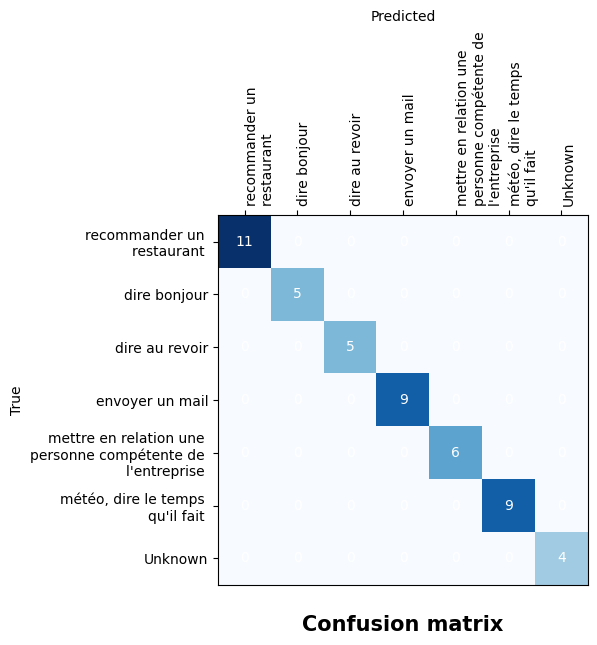

In [21]:
y_pred = clf.predict(X_test)

labels = y.unique()

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred, average='weighted', zero_division=0)}")
print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
print(f"F1: {f1_score(y_test, y_pred, average='weighted')}")

plot_confusion_matrix(y_test, y_pred, labels)

## Classifier Approch from other embeddings